# Gesture Recognition
In this group project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [0]:
!pip uninstall scipy
!pip install scipy==1.1.0
!pip3 install Pillow

Found existing installation: scipy 1.7.3
Uninstalling scipy-1.7.3:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/scipy-1.7.3.dist-info/*
    /usr/local/lib/python3.8/dist-packages/scipy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.8/dist-packages/scipy.libs/libopenblasp-r0-8b9e111f.3.17.so
    /usr/local/lib/python3.8/dist-packages/scipy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.8/dist-packages/scipy/*
Proceed (Y/n)? Y
  Successfully uninstalled scipy-1.7.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 81.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scipy: filename=scipy-1.1.0-cp38-cp38-linux_x86_64.whl size=41841063 sha256=0e33e8a1f2db65824c17055ae8dd0f08971b5e87078fb5efb279d9e49f81955b
  Stored in directory: /root/.cache/pip/wheels/29/a9/5e/9e4eddde37a1e15cf5cb404ba197df482cc39ffbfef91ec337

In [0]:
import numpy as np
import os
from PIL import Image
from scipy import misc
# from scipy.misc import imread, imresize
from scipy.misc.pilutil import imread, imresize
import datetime

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt



In [0]:
## If you are using the data by mounting the google drive, use the following :
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

from google.colab import drive
drive.mount('/content/gdrive')

ROOT_FOLDER = "/content/gdrive/MyDrive/Gesture_Recognition"



Mounted at /content/gdrive


We set the random seed so that the results don't vary drastically.

In [0]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [0]:
train_doc = np.random.permutation(open(f'{ROOT_FOLDER}/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open(f'{ROOT_FOLDER}/Project_data/val.csv').readlines())
batch_size = 15


In [0]:
print('Number of Train sample : ', len(train_doc))
print('Number of Validation sample : ', len(val_doc))

Number of Train sample :  663
Number of Validation sample :  100


# Generator
This is one of the most important part of the code. In the generator, we are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [0]:
# The generator is able to successfully input a batch of videos to the model. Weightages have been allocated to the correct list creation of img_idx, initialization of the batch, 
# correctly looping over the data points in a batch and cropping, resizing and normalisation of the images.


def generator(source_path, folder_list, batch_size, num_image_per_folder, img_height, img_width):
    # print( 'Source path = ', source_path, '; batch size =', batch_size)
    # x = 10 #CHANGE to 30
    # y = 100
    # z = 100   

    
    x = num_image_per_folder
    y = img_height
    z = img_width

    img_idx = [img for img in range(x)]                                                                      #create a list of image numbers you want to use for a particular video


    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size                                                           # calculate the number of batches
        for batch in range(num_batches):                                                                     # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3))                                                      # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5))                                                          # batch_labels is the one hot representation of the output
            for folder in range(batch_size):                                                                 # iterate over the batch_size
                imgs = os.listdir(source_path + '/' + t[folder + (batch*batch_size)].split(';')[0])          # read all the images in the folder
                imgs = sorted(imgs)
                for idx,item in enumerate(img_idx):                                                          #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    if h == 360:
                      image_croped = image[20:340, 20:340 , :]
                    if h == 160:
                      image_croped = image[10:140, 10:140 , :]                                               # Crop images
                    else:
                      image_croped = image[:, : , :]                                               

                    image_resized = imresize(image_croped,(y,z,3))                                           # resized unifrorm images 
                    image_normalized = image_resized / 255                                                   # Normalized data
                    

                    batch_data[folder,idx,:,:,0] = image_normalized[:,:,0] 
                    batch_data[folder,idx,:,:,1] = image_normalized[:,:,1] 
                    batch_data[folder,idx,:,:,2] = image_normalized[:,:,2] 
                
                #     print("idx : ", idx)
                # print(batch_data.shape)
                # print("folder : ", folder)
                # print(batch_data[folder,3,:,:,:])


                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
            yield batch_data, batch_labels                                                                   #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(folder_list) % batch_size > 0:
          Last_batch_size = len(folder_list) % batch_size
          batch_data = np.zeros((Last_batch_size,x,y,z,3))
          batch_labels = np.zeros((Last_batch_size,5)) 

          for folder in range(Last_batch_size):
            imgs = os.listdir(source_path + '/' + t[folder + (num_batches * batch_size)].split(';')[0]) 
            imgs = sorted(imgs)
            for idx,item in enumerate(img_idx):                                                          #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches * batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    if h == 360:
                      image_croped = image[20:340, 20:340 , :]                                               # Crop images  
                    if h == 160:
                      image_croped = image[10:140, 10:140 , :]                                               # Crop images
                    else:
                      image_croped = image[:, : , :]                                               


                    image_resized = imresize(image_croped,(y,z,3))                                           # resized unifrorm images 
                    image_normalized = image_resized / 255                                                   # Normalized data
                    
                    batch_data[folder,idx,:,:,0] = image_normalized[:,:,0] 
                    batch_data[folder,idx,:,:,1] = image_normalized[:,:,1] 
                    batch_data[folder,idx,:,:,2] = image_normalized[:,:,2] 
           
            batch_labels[folder, int(t[folder + (num_batches * batch_size)].strip().split(';')[2])] = 1
          
          # for folder in range(Last_batch_size) :
          #   print(t[folder + (num_batches * batch_size)].split(';')[0])
          #   print(batch_labels[folder, int(t[folder + (num_batches * batch_size)].strip().split(';')[2])])    


          yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [0]:
curr_dt_time = datetime.datetime.now()
train_path = f'{ROOT_FOLDER}/Project_data/train'
val_path = f'{ROOT_FOLDER}/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 5                                                                      # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


## Lets check some random images to check generator is working properly

Source path =  /content/gdrive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 15


Text(0.5, 1.0, ' Gesture label = 4')

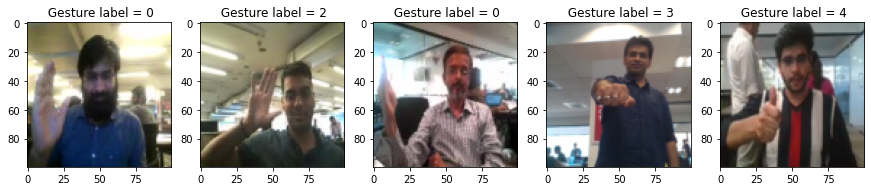

In [0]:
## Lets check some random images to check generator is working


# lets review the generator
num_image_per_folder = 10
img_height = 100
img_width = 100

generator_check = generator(train_path, train_doc, batch_size, num_image_per_folder, img_height, img_width)
batch_data_train, batch_labels_train = next(generator_check)
batch_data_train.shape

fig, ax = plt.subplots(1,5, figsize=(15, 4))


image1 = batch_data_train[0,1,:,:,:] * 255
image2 = batch_data_train[3,1,:,:,:] * 255
image3 = batch_data_train[5,1,:,:,:] * 255
image4 = batch_data_train[8,1,:,:,:] * 255
image5 = batch_data_train[13,1,:,:,:] * 255

ax[0].imshow(image1.astype('uint8'))   
ax[1].imshow(image2.astype('uint8'))   
ax[2].imshow(image3.astype('uint8'))   
ax[3].imshow(image4.astype('uint8'))   
ax[4].imshow(image5.astype('uint8'))   

ax[0].set_title(f' Gesture label = {batch_labels_train[0].argmax(axis=0)}')
ax[1].set_title(f' Gesture label = {batch_labels_train[3].argmax(axis=0)}')
ax[2].set_title(f' Gesture label = {batch_labels_train[5].argmax(axis=0)}')
ax[3].set_title(f' Gesture label = {batch_labels_train[8].argmax(axis=0)}')
ax[4].set_title(f' Gesture label = {batch_labels_train[13].argmax(axis=0)}')


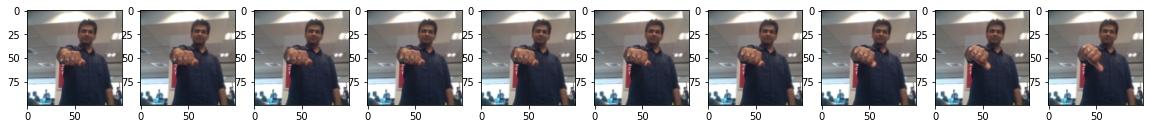

In [0]:
## Lets check one series of image tocheck if labels are correct
fig, ax = plt.subplots(1,10, figsize=(20, 4))

for i in range(10):
  image1 = batch_data_train[8,i,:,:,:] * 255
  ax[i].imshow(image1.astype('uint8'))


## Check generator for validation folder

Text(0.5, 1.0, ' Gesture label = 0')

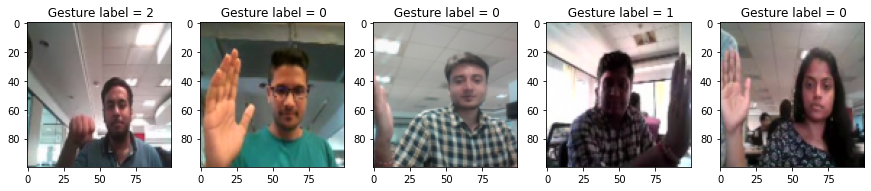

In [0]:

# lets review the generator
num_image_per_folder = 10
img_height = 100
img_width = 100
batch_size = 15

generator_check = generator(val_path, val_doc, batch_size, num_image_per_folder, img_height, img_width)
batch_data_train, batch_labels_train = next(generator_check)
batch_data_train.shape

fig, ax = plt.subplots(1,5, figsize=(15, 4))


image1 = batch_data_train[0,1,:,:,:] * 255
image2 = batch_data_train[3,1,:,:,:] * 255
image3 = batch_data_train[5,1,:,:,:] * 255
image4 = batch_data_train[8,1,:,:,:] * 255
image5 = batch_data_train[13,1,:,:,:] * 255

ax[0].imshow(image1.astype('uint8'))   
ax[1].imshow(image2.astype('uint8'))   
ax[2].imshow(image3.astype('uint8'))   
ax[3].imshow(image4.astype('uint8'))   
ax[4].imshow(image5.astype('uint8'))   

ax[0].set_title(f' Gesture label = {batch_labels_train[0].argmax(axis=0)}')
ax[1].set_title(f' Gesture label = {batch_labels_train[3].argmax(axis=0)}')
ax[2].set_title(f' Gesture label = {batch_labels_train[5].argmax(axis=0)}')
ax[3].set_title(f' Gesture label = {batch_labels_train[8].argmax(axis=0)}')
ax[4].set_title(f' Gesture label = {batch_labels_train[13].argmax(axis=0)}')


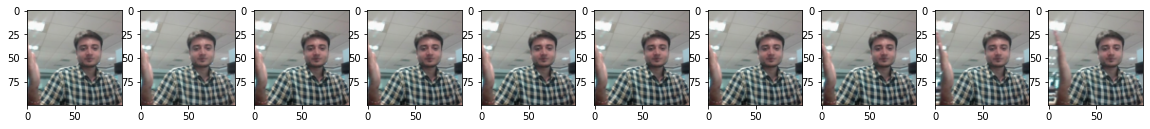

In [0]:
## Lets check one series of image tocheck if labels are correct
fig, ax = plt.subplots(1,10, figsize=(20, 4))

for i in range(10):
  image1 = batch_data_train[5,i,:,:,:] * 255
  ax[i].imshow(image1.astype('uint8'))


# Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, Conv2D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

from sys import getsizeof
#write your model here

In [0]:
### function to plot traning and validation Acc/Loss

def acc_plot(history):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    ax[0].plot(history.history['loss'])   
    ax[0].plot(history.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].set_title("Train vs Validation LOSS")

    ax[1].plot(history.history['categorical_accuracy'])   
    ax[1].plot(history.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])    
    ax[1].set_title("Train vs Validation ACCURACY")
    plt.show()

    print("")
    print("")
    print("---------------------------------------------------------------------------------")
    print("Max. Training Accuracy", round(max(history.history['categorical_accuracy']),3))
    print("Max. Validaiton Accuracy", round(max(history.history['val_categorical_accuracy']),3))



Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [0]:
# optimiser = tf.keras.optimizers.Adam()                                                                           #write your optimizer
# model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [0]:
# train_generator = generator(train_path, train_doc, batch_size, num_image_per_folder, img_height, img_width)
# val_generator = generator(val_path, val_doc, batch_size, num_image_per_folder, img_height, img_width)


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [0]:
# added below part in "model_train" function

# if (num_train_sequences%batch_size) == 0:
#     steps_per_epoch = int(num_train_sequences/batch_size)
# else:
#     steps_per_epoch = (num_train_sequences//batch_size) + 1

# if (num_val_sequences%batch_size) == 0:
#     validation_steps = int(num_val_sequences/batch_size)
# else:
#     validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [0]:
# added below part in "model_train" function

# model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [0]:
## collecting different parts for model run into a function to reuse with different hyper parameters

Model_path = ROOT_FOLDER + "/Project_data/saved_models/"
if not os.path.exists(Model_path):
    os.mkdir(Model_path)


def model_train(model, Model_path, model_name, train_doc, val_doc, batch_size,train_generator,val_generator, num_epochs):


  print("RUNNING MODEL : ", model_name) 
  model_name = Model_path + model_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
  if not os.path.exists(model_name):
      os.mkdir(model_name)
        
  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

  LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)                   # write the REducelronplateau code here
  # earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
  callbacks_list = [checkpoint, LR]
   

  #  The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
  num_train_sequences = len(train_doc)
  num_val_sequences = len(val_doc)

  if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
  else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
  else:
    validation_steps = (num_val_sequences//batch_size) + 1
  
  
  ## Optimizer
  optimiser = tf.keras.optimizers.Adam()                                                                           #write your optimizer
  model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


  # Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

  return history

## Model 1 - CNN 3D
- *Lets try with high batch size 0f 40, and image dim of 160X160 and all images from a folder. just 2 epochs to see my network is working properly.*

In [0]:
batch_size = 40
num_image_per_folder = 30
img_height = 160
img_width = 160
num_epochs = 2
filtersize = (3,3,3)
model_name = "Conv_3D_batch" + str(batch_size) + "_" + str(num_image_per_folder) + "img_" + str(img_height) + "H_" + str(img_width) + "W_" + str(num_epochs) + "eph" + "_flt"+ str(filtersize[0])

# print("Required Memory {} Gigs". format(getsizeof(np.zeros((batch_size,16,num_image_per_folder,img_height,img_width)))/(1024*1024*1024)))

model = Sequential()
model.add(Conv3D(16, filtersize, padding='same',input_shape=(num_image_per_folder,img_height,img_width,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())

model.add(Dense(5,activation='softmax'))

model1 = model
print(model1.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_1 (Conv3D)           (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_1 (Activation)   (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_1 (Batc  (None, 30, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 15, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1536000)           0         
                                                                 
 dense_1 (Dense)             (None, 5)                

In [0]:
train_generator = generator(train_path, train_doc, batch_size, num_image_per_folder, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_image_per_folder, img_height, img_width)

history1 = model_train(model1, Model_path, model_name, train_doc, val_doc, batch_size, train_generator, val_generator, num_epochs)


RUNNING MODEL :  Conv_3D_batch40_30img_160H_160W_2eph_flt3
Epoch 1/2
17/17 [==============================] - ETA: 0s - loss: 116.2972 - categorical_accuracy: 0.4284
Epoch 1: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Project_data/saved_models/Conv_3D_batch40_30img_160H_160W_2eph_flt3_2023-01-0711_39_56.899624/model-00001-116.29720-0.42836-19.83548-0.31000.h5
17/17 [==============================] - 741s 46s/step - loss: 116.2972 - categorical_accuracy: 0.4284 - val_loss: 19.8355 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/2
17/17 [==============================] - ETA: 0s - loss: 8.5004 - categorical_accuracy: 0.8507
Epoch 2: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Project_data/saved_models/Conv_3D_batch40_30img_160H_160W_2eph_flt3_2023-01-0711_39_56.899624/model-00002-8.50036-0.85068-13.32676-0.36000.h5
17/17 [==============================] - 146s 9s/step - loss: 8.5004 - categorical_accuracy: 0.8507 - val_loss: 13.3268 - val_categori

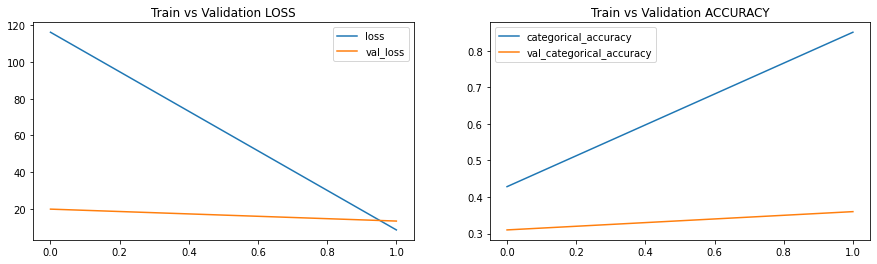



---------------------------------------------------------------------------------
Max. Training Accuracy 0.851
Max. Validaiton Accuracy 0.36


In [0]:
acc_plot(history1)

In [0]:
## making space in Memeory.
model1 = None
history1 = None

## Model 2 - CNN3D
- *Lets try with batch size 0f 20 for more iteration, and image dim of 100X100 will make lower usage of RAM and first 20 images from each folder randomly reveiwed and observed that with first 20 images, we get some movement towards the specific gasture. Now more deeper model that would take higher time more that what we minimized by reducing image size and batch size. Also 25 epochs to aim for better accurecy.*

In [0]:
batch_size = 20
num_image_per_folder = 20
img_height = 100
img_width = 100
num_epochs = 25
filtersize = (3,3,3)
model_name = "Model2_Conv_3D_batch" + str(batch_size) + "_" + str(num_image_per_folder) + "img_" + str(img_height) + "H_" + str(img_width) + "W_" + str(num_epochs) + "eph" + "_flt"+ str(filtersize[0])

# print("Required Memory {} Gigs". format(getsizeof(np.zeros((batch_size,16,num_image_per_folder,img_height,img_width)))/(1024*1024*1024)))


model = Sequential()
model.add(Conv3D(16, filtersize, padding='same',input_shape=(num_image_per_folder,img_height,img_width,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
# model.add(Conv3D(32, filtersize, padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
# model.add(Conv3D(64, filtersize, padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, filtersize, padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
        
# model.add(Conv3D(128, filtersize, padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
        
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(5,activation='softmax'))

model2 = model
print(model2.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 20, 100, 100, 16)  1312      
                                                                 
 activation_2 (Activation)   (None, 20, 100, 100, 16)  0         
                                                                 
 batch_normalization_2 (Batc  (None, 20, 100, 100, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 10, 50, 50, 16)   0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 10, 50, 50, 32)    13856     
                                                                 
 activation_3 (Activation)   (None, 10, 50, 50, 32)   

In [0]:
train_generator = generator(train_path, train_doc, batch_size, num_image_per_folder, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_image_per_folder, img_height, img_width)

history2 = model_train(model2, Model_path, model_name, train_doc, val_doc, batch_size, train_generator, val_generator, num_epochs)


RUNNING MODEL :  Model2_Conv_3D_batch20_20img_100H_100W_25eph_flt3
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.4479 - categorical_accuracy: 0.4344
Epoch 1: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Project_data/saved_models/Model2_Conv_3D_batch20_20img_100H_100W_25eph_flt3_2023-01-0711_39_56.899624/model-00001-1.44790-0.43439-4.04121-0.16000.h5
34/34 [==============================] - 85s 2s/step - loss: 1.4479 - categorical_accuracy: 0.4344 - val_loss: 4.0412 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 0.8408 - categorical_accuracy: 0.6893
Epoch 2: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Project_data/saved_models/Model2_Conv_3D_batch20_20img_100H_100W_25eph_flt3_2023-01-0711_39_56.899624/model-00002-0.84077-0.68929-7.36529-0.18000.h5
34/34 [==============================] - 79s 2s/step - loss: 0.8408 - categorical_accuracy: 0.6893 - val_loss: 7.3653 -

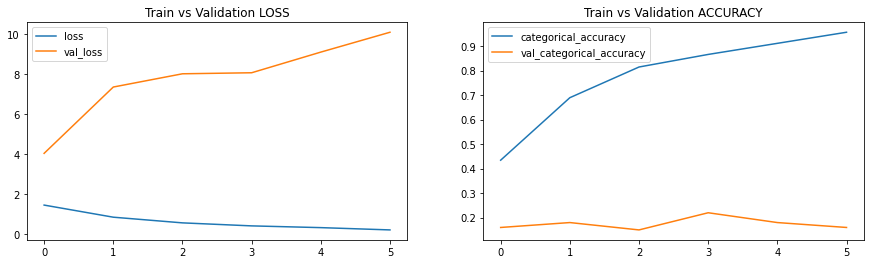



---------------------------------------------------------------------------------
Max. Training Accuracy 0.956
Max. Validaiton Accuracy 0.22


In [0]:
acc_plot(history2)

In [0]:
## making space in Memeory.
model2 = None
history2 = None

## Model 3 - CNN 3D
- *Model2 become an overfitted model. Lets reduce the number of layers and dropout percentages and see how it is working.*

In [0]:
batch_size = 20
num_image_per_folder = 20
img_height = 100
img_width = 100
num_epochs = 20
filtersize = (3,3,3)
model_name = "Model3_Conv_3D_batch" + str(batch_size) + "_" + str(num_image_per_folder) + "img_" + str(img_height) + "H_" + str(img_width) + "W_" + str(num_epochs) + "eph" + "_flt"+ str(filtersize[0])

# print("Required Memory {} Gigs". format(getsizeof(np.zeros((batch_size,16,num_image_per_folder,img_height,img_width)))/(1024*1024*1024)))


model = Sequential()

model.add(Conv3D(16, filtersize, padding='same',input_shape=(num_image_per_folder,img_height,img_width,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(16, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
       
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))


model.add(Dense(5,activation='softmax'))

model3 = model
print(model3.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_5 (Conv3D)           (None, 20, 100, 100, 16)  1312      
                                                                 
 activation_5 (Activation)   (None, 20, 100, 100, 16)  0         
                                                                 
 batch_normalization_7 (Batc  (None, 20, 100, 100, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 10, 50, 50, 16)   0         
 3D)                                                             
                                                                 
 conv3d_6 (Conv3D)           (None, 10, 50, 50, 16)    6928      
                                                                 
 activation_6 (Activation)   (None, 10, 50, 50, 16)   

In [0]:
train_generator = generator(train_path, train_doc, batch_size, num_image_per_folder, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_image_per_folder, img_height, img_width)

history3 = model_train(model3, Model_path, model_name, train_doc, val_doc, batch_size, train_generator, val_generator, num_epochs)


RUNNING MODEL :  Model3_Conv_3D_batch20_20img_100H_100W_20eph_flt3
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3071 - categorical_accuracy: 0.5053
Epoch 1: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Project_data/saved_models/Model3_Conv_3D_batch20_20img_100H_100W_20eph_flt3_2023-01-0711_39_56.899624/model-00001-1.30710-0.50528-2.44578-0.16000.h5
34/34 [==============================] - 80s 2s/step - loss: 1.3071 - categorical_accuracy: 0.5053 - val_loss: 2.4458 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.6903 - categorical_accuracy: 0.7526
Epoch 2: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Project_data/saved_models/Model3_Conv_3D_batch20_20img_100H_100W_20eph_flt3_2023-01-0711_39_56.899624/model-00002-0.69026-0.75264-6.16389-0.14000.h5
34/34 [==============================] - 75s 2s/step - loss: 0.6903 - categorical_accuracy: 0.7526 - val_loss: 6.1639 -

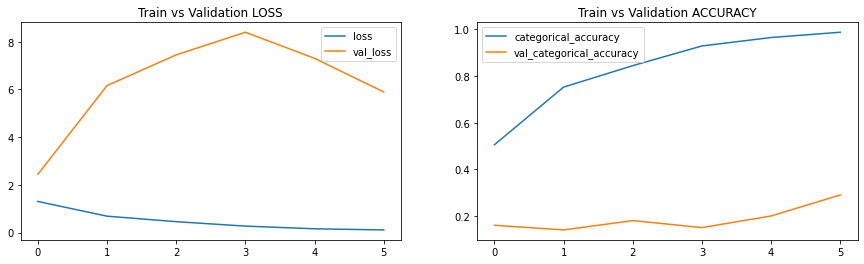



---------------------------------------------------------------------------------
Max. Training Accuracy 0.988
Max. Validaiton Accuracy 0.29


In [0]:
acc_plot(history3)

In [0]:
## making space in Memeory.
model3 = None
history3 = None

## Model 4 - CNN 3D
- *Model3 is still overfitted and Val accuracy not improving. considering Model1, lets try with 160X160 image size and no dropout layer with comparatively deeper network than Model1*
-*we have removed the earlystopping after model 3 run to see how the progress at end of all epochs.*

In [0]:
batch_size = 20
num_image_per_folder = 24
img_height = 160
img_width = 160
num_epochs = 20
filtersize = (3,3,3)
model_name = "Model4_Conv_3D_batch" + str(batch_size) + "_" + str(num_image_per_folder) + "img_" + str(img_height) + "H_" + str(img_width) + "W_" + str(num_epochs) + "eph" + "_flt"+ str(filtersize[0])

# print("Required Memory {} Gigs". format(getsizeof(np.zeros((batch_size,16,num_image_per_folder,img_height,img_width)))/(1024*1024*1024)))

model = Sequential()
model.add(Conv3D(16, filtersize, padding='same',input_shape=(num_image_per_folder,img_height,img_width,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))


model.add(Dense(5,activation='softmax'))

model4 = model
print(model4.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 24, 160, 160, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 24, 160, 160, 16)  0         
                                                                 
 batch_normalization_11 (Bat  (None, 24, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 12, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 12, 80, 80, 32)    13856     
                                                                 
 activation_9 (Activation)   (None, 12, 80, 80, 32)   

In [0]:
train_generator = generator(train_path, train_doc, batch_size, num_image_per_folder, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_image_per_folder, img_height, img_width)

history4 = model_train(model4, Model_path, model_name, train_doc, val_doc, batch_size, train_generator, val_generator, num_epochs)


RUNNING MODEL :  Model4_Conv_3D_batch20_24img_160H_160W_20eph_flt3
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 18.9972 - categorical_accuracy: 0.4193
Epoch 1: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Project_data/saved_models/Model4_Conv_3D_batch20_24img_160H_160W_20eph_flt3_2023-01-0711_39_56.899624/model-00001-18.99724-0.41931-11.87585-0.31000.h5
34/34 [==============================] - 112s 3s/step - loss: 18.9972 - categorical_accuracy: 0.4193 - val_loss: 11.8759 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 2.3852 - categorical_accuracy: 0.6802
Epoch 2: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Project_data/saved_models/Model4_Conv_3D_batch20_24img_160H_160W_20eph_flt3_2023-01-0711_39_56.899624/model-00002-2.38519-0.68024-5.42436-0.39000.h5
34/34 [==============================] - 111s 3s/step - loss: 2.3852 - categorical_accuracy: 0.6802 - val_loss: 5

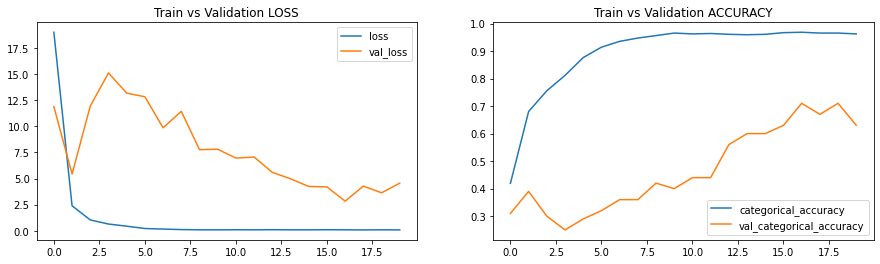



---------------------------------------------------------------------------------
Max. Training Accuracy 0.968
Max. Validaiton Accuracy 0.71


In [0]:
acc_plot(history4)

In [0]:
## making space in Memeory.
model4 = None
history4 = None

##Model 5 - CNN 3D
- *Model 4 shows a good progress. lets increase epochs as val accuacy was still improving. Also added one more Conv layer to make it more deep making it more complex to give better Validaton accuracy. Have tried with 2X2X2 filter, however not giving a good validation accurecy in initial 10 epochs and changed back the filtersize and rerun below model.*

In [0]:
batch_size = 20
num_image_per_folder = 24
img_height = 160
img_width = 160
num_epochs = 40
filtersize = (3,3,3)
model_name = "Model5_V2_Conv_3D_batch" + str(batch_size) + "_" + str(num_image_per_folder) + "img_" + str(img_height) + "H_" + str(img_width) + "W_" + str(num_epochs) + "eph" + "_flt"+ str(filtersize[0])

# print("Required Memory {} Gigs". format(getsizeof(np.zeros((batch_size,16,num_image_per_folder,img_height,img_width)))/(1024*1024*1024)))

model = Sequential()
model.add(Conv3D(16, filtersize, padding='same',input_shape=(num_image_per_folder,img_height,img_width,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))



model.add(Flatten())
model.add(Dense(128,activation='relu'))


model.add(Dense(5,activation='softmax'))

model5 = model
print(model5.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 24, 160, 160, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 24, 160, 160, 16)  0         
                                                                 
 batch_normalization_4 (Batc  (None, 24, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 12, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 12, 80, 80, 32)    13856     
                                                                 
 activation_5 (Activation)   (None, 12, 80, 80, 32)   

In [0]:
train_generator = generator(train_path, train_doc, batch_size, num_image_per_folder, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_image_per_folder, img_height, img_width)

history5 = model_train(model5, Model_path, model_name, train_doc, val_doc, batch_size, train_generator, val_generator, num_epochs)


RUNNING MODEL :  Model5_V2_Conv_3D_batch20_24img_160H_160W_40eph_flt3
Epoch 1/40
34/34 [==============================] - ETA: 0s - loss: 3.5244 - categorical_accuracy: 0.4253
Epoch 1: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Project_data/saved_models/Model5_V2_Conv_3D_batch20_24img_160H_160W_40eph_flt3_2023-01-0715_45_33.444915/model-00001-3.52436-0.42534-5.55030-0.23000.h5
34/34 [==============================] - 108s 3s/step - loss: 3.5244 - categorical_accuracy: 0.4253 - val_loss: 5.5503 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/40
34/34 [==============================] - ETA: 0s - loss: 0.9244 - categorical_accuracy: 0.6305
Epoch 2: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Project_data/saved_models/Model5_V2_Conv_3D_batch20_24img_160H_160W_40eph_flt3_2023-01-0715_45_33.444915/model-00002-0.92440-0.63047-2.00806-0.33000.h5
34/34 [==============================] - 116s 3s/step - loss: 0.9244 - categorical_accuracy: 0.6305 - val_los

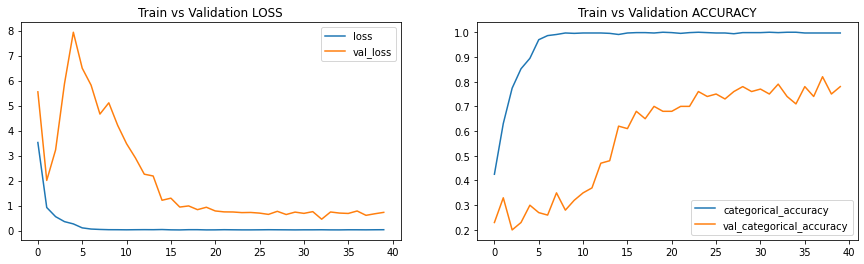



---------------------------------------------------------------------------------
Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.82


In [0]:
acc_plot(history5)

In [0]:
## making space in Memeory.
model5 = None
history5 = None

# - For epoch 38 we get 99.7% train accurecy and 82% of validation accurecy. This is very good result.Lets Try with CNN + RNN and see if we have some bettwer results.

## Model 6 - CNN + RNN
- *Alternative to CNN 3D model due to sequence nature of images, we also can create model Combning CNN 2D and RNN. CNN 2D to extract features and RNN (here i have used GRU) to understand the nature of movement. Lets try with 100X100 image and 25 epochs and see the result.

In [0]:
batch_size = 20
num_image_per_folder = 24
img_height = 100
img_width = 100
num_epochs = 35
filtersize = (3,3)
model_name = "Model6_Conv2D_GRU_batch" + str(batch_size) + "_" + str(num_image_per_folder) + "img_" + str(img_height) + "H_" + str(img_width) + "W_" + str(num_epochs) + "eph" + "_flt"+ str(filtersize[0])


model = Sequential()

model.add(TimeDistributed(Conv2D(16, filtersize , padding='same', activation='relu'), input_shape=(num_image_per_folder,img_height,img_width,3)))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, filtersize , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, filtersize , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, filtersize , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(256, filtersize , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

# model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(GRU(128))
# model.add(Dropout(0.15))

model.add(Dense(128,activation='relu'))
# model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

model6 = model
print(model6.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_45 (TimeDi  (None, 24, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 24, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_47 (TimeDi  (None, 24, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_48 (TimeDi  (None, 24, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 24, 50, 50, 32)  

In [0]:
train_generator = generator(train_path, train_doc, batch_size, num_image_per_folder, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_image_per_folder, img_height, img_width)

history6 = model_train(model6, Model_path, model_name, train_doc, val_doc, batch_size, train_generator, val_generator, num_epochs)


RUNNING MODEL :  Model6_Conv2D_GRU_batch20_24img_100H_100W_35eph_flt3
Epoch 1/35
34/34 [==============================] - ETA: 0s - loss: 1.2840 - categorical_accuracy: 0.4630
Epoch 1: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Project_data/saved_models/Model6_Conv2D_GRU_batch20_24img_100H_100W_35eph_flt3_2023-01-0809_15_50.391046/model-00001-1.28403-0.46305-2.07850-0.16000.h5
34/34 [==============================] - 92s 3s/step - loss: 1.2840 - categorical_accuracy: 0.4630 - val_loss: 2.0785 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/35
34/34 [==============================] - ETA: 0s - loss: 0.8425 - categorical_accuracy: 0.6712
Epoch 2: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Project_data/saved_models/Model6_Conv2D_GRU_batch20_24img_100H_100W_35eph_flt3_2023-01-0809_15_50.391046/model-00002-0.84254-0.67119-2.33886-0.17000.h5
34/34 [==============================] - 90s 3s/step - loss: 0.8425 - categorical_accuracy: 0.6712 - val_loss:

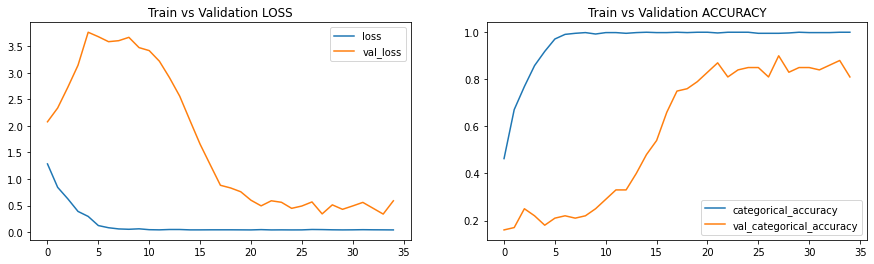



---------------------------------------------------------------------------------
Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.9


In [0]:
acc_plot(history6)

## Model 7 - CNN 2D + RNN
- *Lowering batch size expecting a smoother increment in accurecy*


In [0]:
batch_size = 10
num_image_per_folder = 24
img_height = 100
img_width = 100
num_epochs = 35
filtersize = (3,3)
model_name = "Model7_Conv2D_GRU_batch" + str(batch_size) + "_" + str(num_image_per_folder) + "img_" + str(img_height) + "H_" + str(img_width) + "W_" + str(num_epochs) + "eph" + "_flt"+ str(filtersize[0])


model = Sequential()

model.add(TimeDistributed(Conv2D(16, filtersize , padding='same', activation='relu'), input_shape=(num_image_per_folder,img_height,img_width,3)))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, filtersize , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, filtersize , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, filtersize , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(256, filtersize , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

# model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(GRU(64))
# model.add(Dropout(0.15))

model.add(Dense(128,activation='relu'))
# model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

model7 = model
print(model7.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_61 (TimeDi  (None, 24, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_62 (TimeDi  (None, 24, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_63 (TimeDi  (None, 24, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_64 (TimeDi  (None, 24, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 24, 50, 50, 32)  

In [0]:
train_generator = generator(train_path, train_doc, batch_size, num_image_per_folder, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_image_per_folder, img_height, img_width)

history7 = model_train(model7, Model_path, model_name, train_doc, val_doc, batch_size, train_generator, val_generator, num_epochs)


RUNNING MODEL :  Model7_Conv2D_GRU_batch10_24img_100H_100W_35eph_flt3
Epoch 1/35
67/67 [==============================] - ETA: 0s - loss: 1.2911 - categorical_accuracy: 0.4661
Epoch 1: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Project_data/saved_models/Model7_Conv2D_GRU_batch10_24img_100H_100W_35eph_flt3_2023-01-0809_15_50.391046/model-00001-1.29112-0.46606-2.14933-0.16000.h5
67/67 [==============================] - 99s 1s/step - loss: 1.2911 - categorical_accuracy: 0.4661 - val_loss: 2.1493 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/35
67/67 [==============================] - ETA: 0s - loss: 0.9593 - categorical_accuracy: 0.6275
Epoch 2: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Project_data/saved_models/Model7_Conv2D_GRU_batch10_24img_100H_100W_35eph_flt3_2023-01-0809_15_50.391046/model-00002-0.95927-0.62745-3.15774-0.16000.h5
67/67 [==============================] - 90s 1s/step - loss: 0.9593 - categorical_accuracy: 0.6275 - val_loss:

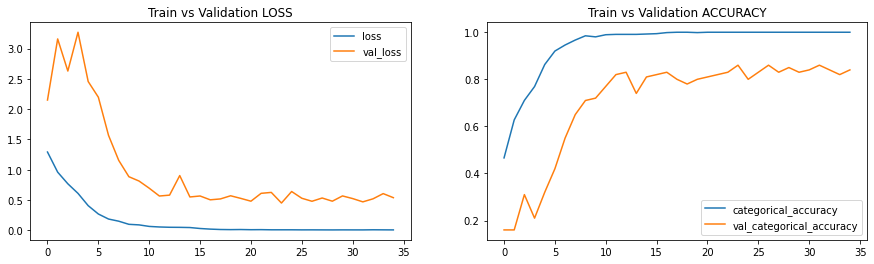



---------------------------------------------------------------------------------
Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.86


In [0]:
acc_plot(history7)

## Model 8

In [0]:
batch_size = 10
num_image_per_folder = 24
img_height = 100
img_width = 100
num_epochs = 30
filtersize = (3,3)
model_name = "Model8_Conv2D_GRU_Dropot_batch" + str(batch_size) + "_" + str(num_image_per_folder) + "img_" + str(img_height) + "H_" + str(img_width) + "W_" + str(num_epochs) + "eph" + "_flt"+ str(filtersize[0])


model = Sequential()

model.add(TimeDistributed(Conv2D(16, filtersize , padding='same', activation='relu'), input_shape=(num_image_per_folder,img_height,img_width,3)))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, filtersize , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, filtersize , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, filtersize , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(256, filtersize , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

# model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(GRU(64))
model.add(Dropout(0.25))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

model8 = model
print(model8.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_77 (TimeDi  (None, 24, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_78 (TimeDi  (None, 24, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_79 (TimeDi  (None, 24, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_80 (TimeDi  (None, 24, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_81 (TimeDi  (None, 24, 50, 50, 32)  

In [0]:
train_generator = generator(train_path, train_doc, batch_size, num_image_per_folder, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, num_image_per_folder, img_height, img_width)

history8 = model_train(model8, Model_path, model_name, train_doc, val_doc, batch_size, train_generator, val_generator, num_epochs)


RUNNING MODEL :  Model8_Conv2D_GRU_Dropot_batch10_24img_100H_100W_30eph_flt3
Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.4720 - categorical_accuracy: 0.3650
Epoch 1: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Project_data/saved_models/Model8_Conv2D_GRU_Dropot_batch10_24img_100H_100W_30eph_flt3_2023-01-0809_15_50.391046/model-00001-1.47203-0.36501-2.38311-0.21000.h5
67/67 [==============================] - 94s 1s/step - loss: 1.4720 - categorical_accuracy: 0.3650 - val_loss: 2.3831 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.2104 - categorical_accuracy: 0.4902
Epoch 2: saving model to /content/gdrive/MyDrive/Gesture_Recognition/Project_data/saved_models/Model8_Conv2D_GRU_Dropot_batch10_24img_100H_100W_30eph_flt3_2023-01-0809_15_50.391046/model-00002-1.21036-0.49020-2.24213-0.16000.h5
67/67 [==============================] - 91s 1s/step - loss: 1.2104 - categorical_accurac

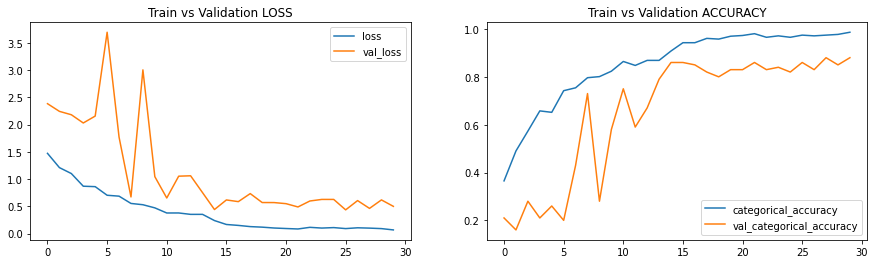



---------------------------------------------------------------------------------
Max. Training Accuracy 0.986
Max. Validaiton Accuracy 0.88


In [0]:
acc_plot(history8)

## Final Model - Model 8 Cnnv2D + GRU
### - So we achived 98.6% train accuracy and 88% of validaton accuracy with Model 8 having Conv2D + GRU network
### - Number of parameters also less comparaed to Cnnv3D models.
### - Improvement of Traning and Validation accuracy also more similar.



#END